<a href="https://colab.research.google.com/github/behdad13/time-series-forecasting/blob/main/TCN_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing necessary libraries 

In [1]:
#installing necessary libraries
!pip install torch
!pip install optuna
!pip install tsai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 33.7 MB/s 
     |████████████████████████████████| 210 kB 69.9 MB/s 
     |████████████████████████████████| 81 kB 8.4 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 147 kB 59.2 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 112 kB 57.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=6a8dab2d64f8a536326cbc90ebcbb88222a255ec30e5364628fa0d43ca0d5654
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Unins

In [2]:
#import necessary libraries
import os
import random
import time
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import array
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#libraries for a TCN structure
from torch.nn.utils import weight_norm
from tsai.imports import *
from tsai.utils import *
from tsai.models.layers import *
from tsai.models.utils import *

In [26]:
#set seed
seed_val = 67
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## importing pre-processed dataset

In [29]:
#import the dataset
data = pd.read_csv('Data_Toronto.csv', low_memory=False)

#select the most relevent feature from the dataset
data = data[['Year', 'Month', 'Day', 'Hour', 'week_end','temperature', 'humidex', 'Ontario_Real_price', 'Electricity_Load']]

In [30]:
#define the test and train set
seq = 5*24
horizon = 24
train = data.iloc[17520+8760+8786 - seq : 43824 + horizon]
test = data.iloc[43824 - seq : 43824+30*24 + horizon]

## train-val-test split

In [31]:
#defining the training proportion
#seperating train and validation set
train_size = int(len(data)*0.80)      
valid_size = int(len(data)*0.20)
df_train, df_val = data[:train_size], data[train_size+1:]
df_train.shape, df_val.shape, test.shape

((38534, 9), (9633, 9), (864, 9))

In [32]:
# scaling each features of the dataset
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train),index = df_train.index, columns = df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val),index = df_val.index, columns = df_val.columns)
test = pd.DataFrame(scaler.transform(test),index = test.index, columns = test.columns)

## Make a time sequneces

In [33]:
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()
test = test.to_numpy()

In [34]:
# split a multivariate sequence into samples
from numpy import array
def split_sequences(sequences, n_steps, for_hor):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-for_hor:
            break
        # gather input and output parts of the pattern
        # sequence_x ranges from 0 to seq_len and all columns except the last one.
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:end_ix+for_hor, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [35]:
n_timesteps = 24*5
for_hor = 24
X_train, y_train = split_sequences(df_train, n_timesteps, for_hor)
X_val, y_val = split_sequences(df_val, n_timesteps, for_hor)
X_test, y_test = split_sequences(test, n_timesteps, for_hor)

In [36]:
print(X_test.shape, y_test.shape)

(721, 120, 9) (721, 24)


In [37]:
n_timesteps + len(X_train) + for_hor-1 == len(df_train)

True

 ## Data Loader

In [38]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64


X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t = torch.Tensor(y_val)
X_test_t = torch.Tensor(X_test)
y_test_t = torch.Tensor(y_test)

train = TensorDataset(X_train_t, y_train_t)
val = TensorDataset(X_val_t, y_val_t)
test_w1 = TensorDataset(X_test_t, y_test_t)


train_loader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle = False, drop_last=True)
test_loader_one_w1 = DataLoader(test_w1, batch_size=1, shuffle = False, drop_last=True)

In [39]:
#check the size of the train set
X_train_t.shape, y_train_t.shape

(torch.Size([38391, 120, 9]), torch.Size([38391, 24]))

In [40]:
#just for testing the size of the batch
next(iter(train_loader))[1].size(), next(iter(train_loader))[0].size()

(torch.Size([64, 24]), torch.Size([64, 120, 9]))

## deep learning model

TCN structure (code is based on the TSAI library)


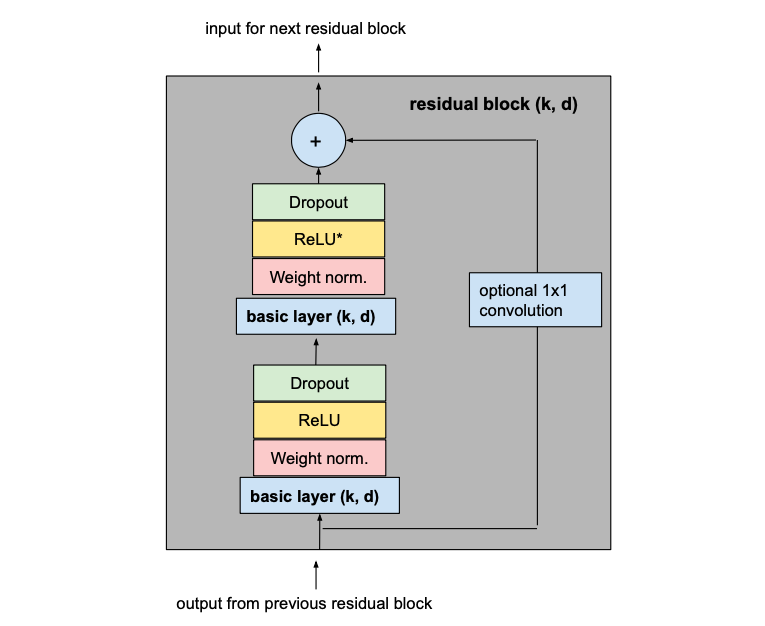

In [41]:
#making a residual block
class TemporalBlock(Module):
    def __init__(self, ni, nf, ks, stride, dilation, padding, dropout=0.):

        #the first step #torch.nn.utils.weight_norm()
        self.conv1 = nn.Conv1d(ni,nf,ks,stride=stride,padding=padding,dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        #the second step
        self.conv2 = nn.Conv1d(nf,nf,ks,stride=stride,padding=padding,dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        #make the sequential series
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1, 
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        
        #the parallel stream
        self.downsample = nn.Conv1d(ni,nf,1) if ni != nf else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None: self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

building the sequence

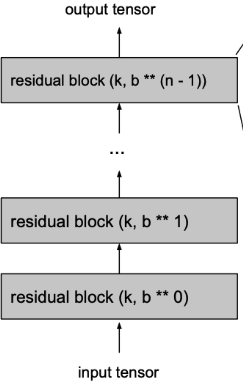

In [42]:
def TemporalConvNet(c_in, layers, ks=2, dropout=0.):
    temp_layers = []
    for i in range(len(layers)):
        dilation_size = 2 ** i
        ni = c_in if i == 0 else layers[i-1]
        nf = layers[i]
        temp_layers += [TemporalBlock(ni, nf, ks, stride=1, dilation=dilation_size, padding=(ks-1) * dilation_size, dropout=dropout)]
    return nn.Sequential(*temp_layers)

build the final model

In [43]:
class TCN(Module):
    def __init__(self, c_in, c_out, seq_len=120, layers=4*[16], ks=4, conv_dropout=0., fc_dropout=0.):
        #parameters guide: c_in = input dimension, c_out = output dimension, layers = number and size of the layer for residual blocks, ks = kernel size(TCN kernel)
        
        self.tcn = TemporalConvNet(c_in, layers, ks=ks, dropout=conv_dropout)
        self.dropout = nn.Dropout(fc_dropout) if fc_dropout else None
        self.linear = nn.Linear(layers[-1]*120,c_out)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.tcn(x)
        #print(x.shape)
        if self.dropout is not None: x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        out = self.linear(x)
        return out

In [44]:
#checking dimensions of the GRU layers
x = torch.rand(64, 120, 9)
model = TCN(c_in = 9,
            seq_len = 120, 
            layers=4*[16],
            ks=3,
            c_out=24)

y = model(x)
y.shape

torch.Size([64, 24])

In [45]:
#defining an objective function of the bayesian Optimization and which parameters need to be tuned
epochs = 250 
patience = 20
loss = nn.MSELoss()
min_val_loss_total=np.inf

def objective(trial):
    #define the infinity variable
    min_val_loss = np.inf
    
    L_size = trial.suggest_int("hidden_layer", 16, 64)
    # Generate the model.
    model = TCN(c_in = 9, 
            layers=4*[L_size],
            ks=trial.suggest_int("TCN_kernel_size", 2, 5),
            c_out=24).cuda()
            #hidden_size2 = trial.suggest_int("hidden_dim2", 16, 128),    

    # Generate the optimizers.
    loss_fn = nn.MSELoss() 
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Training of the model.
    counter = 0
    for i in range(epochs):
        mse_train = 0
        iteration_start = time.monotonic()
        for batch_x, batch_y in train_loader :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            y_pred = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                output = model(batch_x)
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        if min_val_loss > mse_val:
            min_val_loss = mse_val
            counter = 0
        else: 
            counter += 1
        if counter == patience:
            break   

        global min_val_loss_total
        if min_val_loss_total > mse_val:
            min_val_loss_total = mse_val
            torch.save(model.state_dict(), "TCN_BO.pt")

        if i % 20 == 0:
            print("Iter: ", i, "train: ", (mse_train), "val: ", (mse_val))
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        trial.report(min_val_loss, i)
        
    return min_val_loss

In [46]:
if __name__ == "__main__":
    #create the study
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    #calling the optimzation process
    study.optimize(objective, n_trials=40)  

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-24 23:42:50,569] A new study created in memory with name: no-name-120144c8-53b6-478a-868c-6fd89a201884


Iter:  0 train:  802.4912232756615 val:  72.87159223854542
Iter:  20 train:  72.32825269550085 val:  28.276153778657317
Iter:  40 train:  60.870474364608526 val:  23.407604386098683
Iter:  60 train:  54.41235167533159 val:  22.76291896495968
Iter:  80 train:  49.373582024127245 val:  25.450960149988532


[I 2022-12-24 23:51:02,568] Trial 0 finished with value: 22.095528499223292 and parameters: {'hidden_layer': 25, 'TCN_kernel_size': 5, 'lr': 6.784171167864206e-05}. Best is trial 0 with value: 22.095528499223292.


Iter:  0 train:  953.6098104715347 val:  195.6681356728077
Iter:  20 train:  87.05543109029531 val:  27.848741743713617
Iter:  40 train:  71.9508291259408 val:  24.64042468275875
Iter:  60 train:  65.56935415044427 val:  22.71945965755731
Iter:  80 train:  61.97487870976329 val:  22.071423024870455
Iter:  100 train:  59.18039294704795 val:  21.981513735838234
Iter:  120 train:  56.75461807101965 val:  21.57684590574354
Iter:  140 train:  54.91180432215333 val:  22.092028377577662
Iter:  160 train:  52.73844825848937 val:  22.25049035437405
Iter:  180 train:  51.23542495444417 val:  20.875650569796562


[I 2022-12-25 00:06:51,157] Trial 1 finished with value: 20.875650569796562 and parameters: {'hidden_layer': 31, 'TCN_kernel_size': 2, 'lr': 4.508218504978507e-05}. Best is trial 1 with value: 20.875650569796562.


Iter:  0 train:  1067.1924365758896 val:  240.38805723190308
Iter:  20 train:  113.70894632488489 val:  35.389281678944826
Iter:  40 train:  94.37663159519434 val:  29.621773898601532
Iter:  60 train:  80.7313642129302 val:  27.288483574986458
Iter:  80 train:  74.73677934333682 val:  25.56951961480081
Iter:  100 train:  72.35921066254377 val:  24.816054007969797
Iter:  120 train:  70.2813440784812 val:  24.44972214102745
Iter:  140 train:  68.43452465161681 val:  23.96519408747554
Iter:  160 train:  66.98256121948361 val:  23.657128667924553
Iter:  180 train:  65.55946343019605 val:  23.30236680712551
Iter:  200 train:  64.20153781399131 val:  23.022453394718468
Iter:  220 train:  62.82617511972785 val:  23.362271547317505
Iter:  240 train:  61.78832605108619 val:  22.987438111566007


[I 2022-12-25 00:27:28,558] Trial 2 finished with value: 22.653951866552234 and parameters: {'hidden_layer': 24, 'TCN_kernel_size': 3, 'lr': 1.956656305487187e-05}. Best is trial 1 with value: 20.875650569796562.


Iter:  0 train:  864.0349461138248 val:  101.31930696219206
Iter:  20 train:  71.86247945576906 val:  25.211725255474448
Iter:  40 train:  59.30878020823002 val:  23.236203618347645
Iter:  60 train:  52.574881706386805 val:  21.939212660305202
Iter:  80 train:  47.99851709976792 val:  21.362968489527702


[I 2022-12-25 00:35:05,326] Trial 3 finished with value: 21.23994290828705 and parameters: {'hidden_layer': 54, 'TCN_kernel_size': 3, 'lr': 5.190514896375311e-05}. Best is trial 1 with value: 20.875650569796562.


Iter:  0 train:  424.11445005238056 val:  45.727677365764976
Iter:  20 train:  53.80484554544091 val:  23.68030267767608


[I 2022-12-25 00:38:08,442] Trial 4 finished with value: 22.714007928967476 and parameters: {'hidden_layer': 51, 'TCN_kernel_size': 2, 'lr': 0.0002538871856178526}. Best is trial 1 with value: 20.875650569796562.


Iter:  0 train:  637.9513573348522 val:  59.20330473408103
Iter:  20 train:  66.9117654338479 val:  24.547483093105257
Iter:  40 train:  54.13958961889148 val:  24.181427453644574


[I 2022-12-25 00:41:43,021] Trial 5 pruned. 


Iter:  0 train:  961.8770326375961 val:  216.21630719304085


[I 2022-12-25 00:42:16,966] Trial 6 pruned. 


Iter:  0 train:  1033.5721541643143 val:  236.78467845916748


[I 2022-12-25 00:42:51,268] Trial 7 pruned. 


Iter:  0 train:  488.0291530638933 val:  46.55416052043438
Iter:  20 train:  60.063756842166185 val:  24.702737420797348


[I 2022-12-25 00:45:31,053] Trial 8 pruned. 


Iter:  0 train:  423.94546104967594 val:  48.231788109987974
Iter:  20 train:  38.99977998062968 val:  28.882352680899203


[I 2022-12-25 00:47:56,730] Trial 9 finished with value: 23.348742720670998 and parameters: {'hidden_layer': 48, 'TCN_kernel_size': 3, 'lr': 0.00044873871607948793}. Best is trial 1 with value: 20.875650569796562.


Iter:  0 train:  912.6824282407761 val:  138.44523376226425


[I 2022-12-25 00:48:31,928] Trial 10 pruned. 


Iter:  0 train:  538.2977824211121 val:  56.8852092474699


[I 2022-12-25 00:50:10,121] Trial 11 pruned. 


Iter:  0 train:  978.5709180831909 val:  208.62561032176018


[I 2022-12-25 00:50:42,773] Trial 12 pruned. 


Iter:  0 train:  450.0570723116398 val:  44.0525866728276
Iter:  20 train:  50.56928297132254 val:  24.617418218404055
Iter:  40 train:  37.38902996107936 val:  26.90823206398636


[I 2022-12-25 00:54:17,138] Trial 13 pruned. 


Iter:  0 train:  504.5091504752636 val:  50.01454886421561
Iter:  20 train:  50.920520052313805 val:  26.084380846470594


[I 2022-12-25 00:57:21,619] Trial 14 finished with value: 23.834638870321214 and parameters: {'hidden_layer': 56, 'TCN_kernel_size': 4, 'lr': 0.00012082327166340663}. Best is trial 1 with value: 20.875650569796562.


Iter:  0 train:  916.5089879631996 val:  149.92277079820633


[I 2022-12-25 00:57:54,262] Trial 15 pruned. 


Iter:  0 train:  967.764437019825 val:  188.79604741930962


[I 2022-12-25 00:58:29,012] Trial 16 pruned. 


Iter:  0 train:  1140.0180716514587 val:  237.4758762717247


[I 2022-12-25 00:59:03,413] Trial 17 pruned. 


Iter:  0 train:  569.0464729964733 val:  58.509900365024805
Iter:  20 train:  63.1543623842299 val:  23.56844017840922
Iter:  40 train:  51.93539958447218 val:  22.319052699953318


[I 2022-12-25 01:03:15,698] Trial 18 finished with value: 21.541613128967583 and parameters: {'hidden_layer': 40, 'TCN_kernel_size': 3, 'lr': 0.00010199404414729891}. Best is trial 1 with value: 20.875650569796562.


Iter:  0 train:  871.7860987782478 val:  112.43663753569126


[I 2022-12-25 01:03:50,381] Trial 19 pruned. 


Iter:  0 train:  633.984983548522 val:  56.09746616706252
Iter:  20 train:  63.63183552771807 val:  23.839098089374602
Iter:  40 train:  52.80400763824582 val:  20.958157340995967
Iter:  60 train:  44.914668057113886 val:  22.227373527362943


[I 2022-12-25 01:09:38,862] Trial 20 finished with value: 20.758739296346903 and parameters: {'hidden_layer': 57, 'TCN_kernel_size': 2, 'lr': 0.00012084157436312807}. Best is trial 20 with value: 20.758739296346903.


Iter:  0 train:  493.56334306299686 val:  51.85351821780205
Iter:  20 train:  58.231788627803326 val:  23.00238941796124
Iter:  40 train:  44.37698320671916 val:  25.936279429122806


[I 2022-12-25 01:13:45,500] Trial 21 finished with value: 22.349628737196326 and parameters: {'hidden_layer': 59, 'TCN_kernel_size': 2, 'lr': 0.00014445596809834708}. Best is trial 20 with value: 20.758739296346903.


Iter:  0 train:  702.3821227550507 val:  64.51735855266452


[I 2022-12-25 01:14:21,074] Trial 22 pruned. 


Iter:  0 train:  932.8128018379211 val:  147.55121159553528


[I 2022-12-25 01:14:54,884] Trial 23 pruned. 


Iter:  0 train:  731.6912357807159 val:  87.83869557827711


[I 2022-12-25 01:15:29,437] Trial 24 pruned. 


Iter:  0 train:  468.6493642926216 val:  43.75052586570382


[I 2022-12-25 01:16:47,527] Trial 25 pruned. 


Iter:  0 train:  443.4722066372633 val:  43.97039710730314
Iter:  20 train:  44.8003877364099 val:  22.626599229872227


[I 2022-12-25 01:19:51,606] Trial 26 finished with value: 21.526422292925417 and parameters: {'hidden_layer': 59, 'TCN_kernel_size': 2, 'lr': 0.0003402456322657453}. Best is trial 20 with value: 20.758739296346903.


Iter:  0 train:  636.9695018082857 val:  57.38577564433217


[I 2022-12-25 01:20:25,712] Trial 27 pruned. 


Iter:  0 train:  1002.8688170909882 val:  217.42836365103722


[I 2022-12-25 01:20:59,604] Trial 28 pruned. 


Iter:  0 train:  524.826339751482 val:  70.6001667380333


[I 2022-12-25 01:21:32,515] Trial 29 pruned. 


Iter:  0 train:  572.0192312300205 val:  57.53322805091739


[I 2022-12-25 01:22:09,032] Trial 30 pruned. 


Iter:  0 train:  397.80429638922215 val:  44.45096753910184


[I 2022-12-25 01:23:46,017] Trial 31 pruned. 


Iter:  0 train:  377.7162335664034 val:  39.05421805381775
Iter:  20 train:  46.91712889075279 val:  23.361529977992177


[I 2022-12-25 01:26:51,867] Trial 32 finished with value: 22.381641879677773 and parameters: {'hidden_layer': 54, 'TCN_kernel_size': 2, 'lr': 0.0004259697260140169}. Best is trial 20 with value: 20.758739296346903.


Iter:  0 train:  450.687530875206 val:  41.87908083200455
Iter:  20 train:  47.752341847866774 val:  25.286343100480735


[I 2022-12-25 01:29:46,363] Trial 33 finished with value: 22.67356457747519 and parameters: {'hidden_layer': 48, 'TCN_kernel_size': 2, 'lr': 0.0009978084799825088}. Best is trial 20 with value: 20.758739296346903.


Iter:  0 train:  411.99490074813366 val:  45.559624925255775
Iter:  20 train:  48.37727679312229 val:  23.157781461253762


[I 2022-12-25 01:32:43,880] Trial 34 finished with value: 21.67786538321525 and parameters: {'hidden_layer': 64, 'TCN_kernel_size': 2, 'lr': 0.0003049597182453784}. Best is trial 20 with value: 20.758739296346903.


Iter:  0 train:  429.4126234650612 val:  44.8827093988657


[I 2022-12-25 01:33:46,690] Trial 35 pruned. 


Iter:  0 train:  1043.9504327774048 val:  239.7670412659645


[I 2022-12-25 01:34:21,732] Trial 36 pruned. 


Iter:  0 train:  708.0494995117188 val:  80.930738247931


[I 2022-12-25 01:34:52,789] Trial 37 pruned. 


Iter:  0 train:  407.45223316550255 val:  42.181735564023256


[I 2022-12-25 01:35:59,835] Trial 38 pruned. 


Iter:  0 train:  970.8103787899017 val:  182.94705241918564


[I 2022-12-25 01:36:33,684] Trial 39 pruned. 


Study statistics: 
  Number of finished trials:  40
  Number of pruned trials:  26
  Number of complete trials:  14
Best trial:
  Value:  20.758739296346903
  Params: 
    hidden_layer: 57
    TCN_kernel_size: 2
    lr: 0.00012084157436312807


<ipython-input-47-edcffdeaeb42>:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["hidden_layer", "TCN_kernel_size", "lr" ])


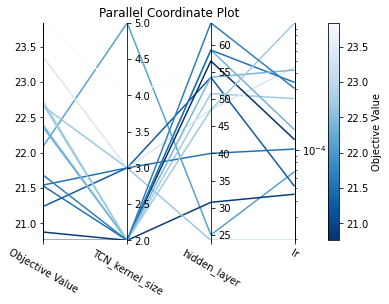

In [47]:
#Visualizing sets of tunned yperparameters based on the BO
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["hidden_layer", "TCN_kernel_size", "lr" ])
optuna.visualization.plot_param_importances(study)

In [48]:
#Download the PT file
from google.colab import files
files.download('TCN_BO.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
#Read the pk file
model = TCN(c_in = 9, 
            layers=4*[57],
            ks=2,
            c_out=24).cuda()

model.load_state_dict(torch.load("TCN_BO.pt"))

<All keys matched successfully>

In [50]:
#call a desacaler function for the further analysis
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [51]:
# the error calculation function
def calculate_metrics(values_descaled, prediction_descaled):
    result_metrics = {
                      'MAE' : mean_absolute_error(values_descaled, prediction_descaled),
                      'MSE' : mean_squared_error(values_descaled, prediction_descaled),
                      'R2'  : r2_score(values_descaled, prediction_descaled),
                      'MAPE': mean_absolute_percentage_error(values_descaled, prediction_descaled)
                      }
    print("Root Mean Squared Error :  ", result_metrics["MSE"]**0.5)
    print("R^2                :       ", result_metrics["R2"])
    print("Mean Absolute Error:       ", result_metrics["MAE"])
    print("MAPE               :       ", result_metrics["MAPE"])
    
    return result_metrics

Test set results

In [52]:
# feeding the model with the test set.
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader_one_w1:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)

Illustration of one-step, two-step, three-step, and 24-step ahead forecasting

error for next 1 hour prediction
Root Mean Squared Error :   76.21879680132986
R^2                :        0.9889647544625243
Mean Absolute Error:        59.54632610686113
MAPE               :        0.010098949415562839


error for next 2 hour prediction
Root Mean Squared Error :   95.33906807604993
R^2                :        0.9825203530195469
Mean Absolute Error:        74.3917668060853
MAPE               :        0.01247880739813009


error for next 3 hour prediction
Root Mean Squared Error :   114.19885790813899
R^2                :        0.974238904252146
Mean Absolute Error:        90.47306868173544
MAPE               :        0.015095259032147144


error for next 24 hour prediction
Root Mean Squared Error :   251.2174979520008
R^2                :        0.8661626569513392
Mean Absolute Error:        195.26876225782334
MAPE               :        0.03313549980616138


1-step ahead forecast
2-step ahead forecast
3-step ahead forecast
24-step ahead forecast


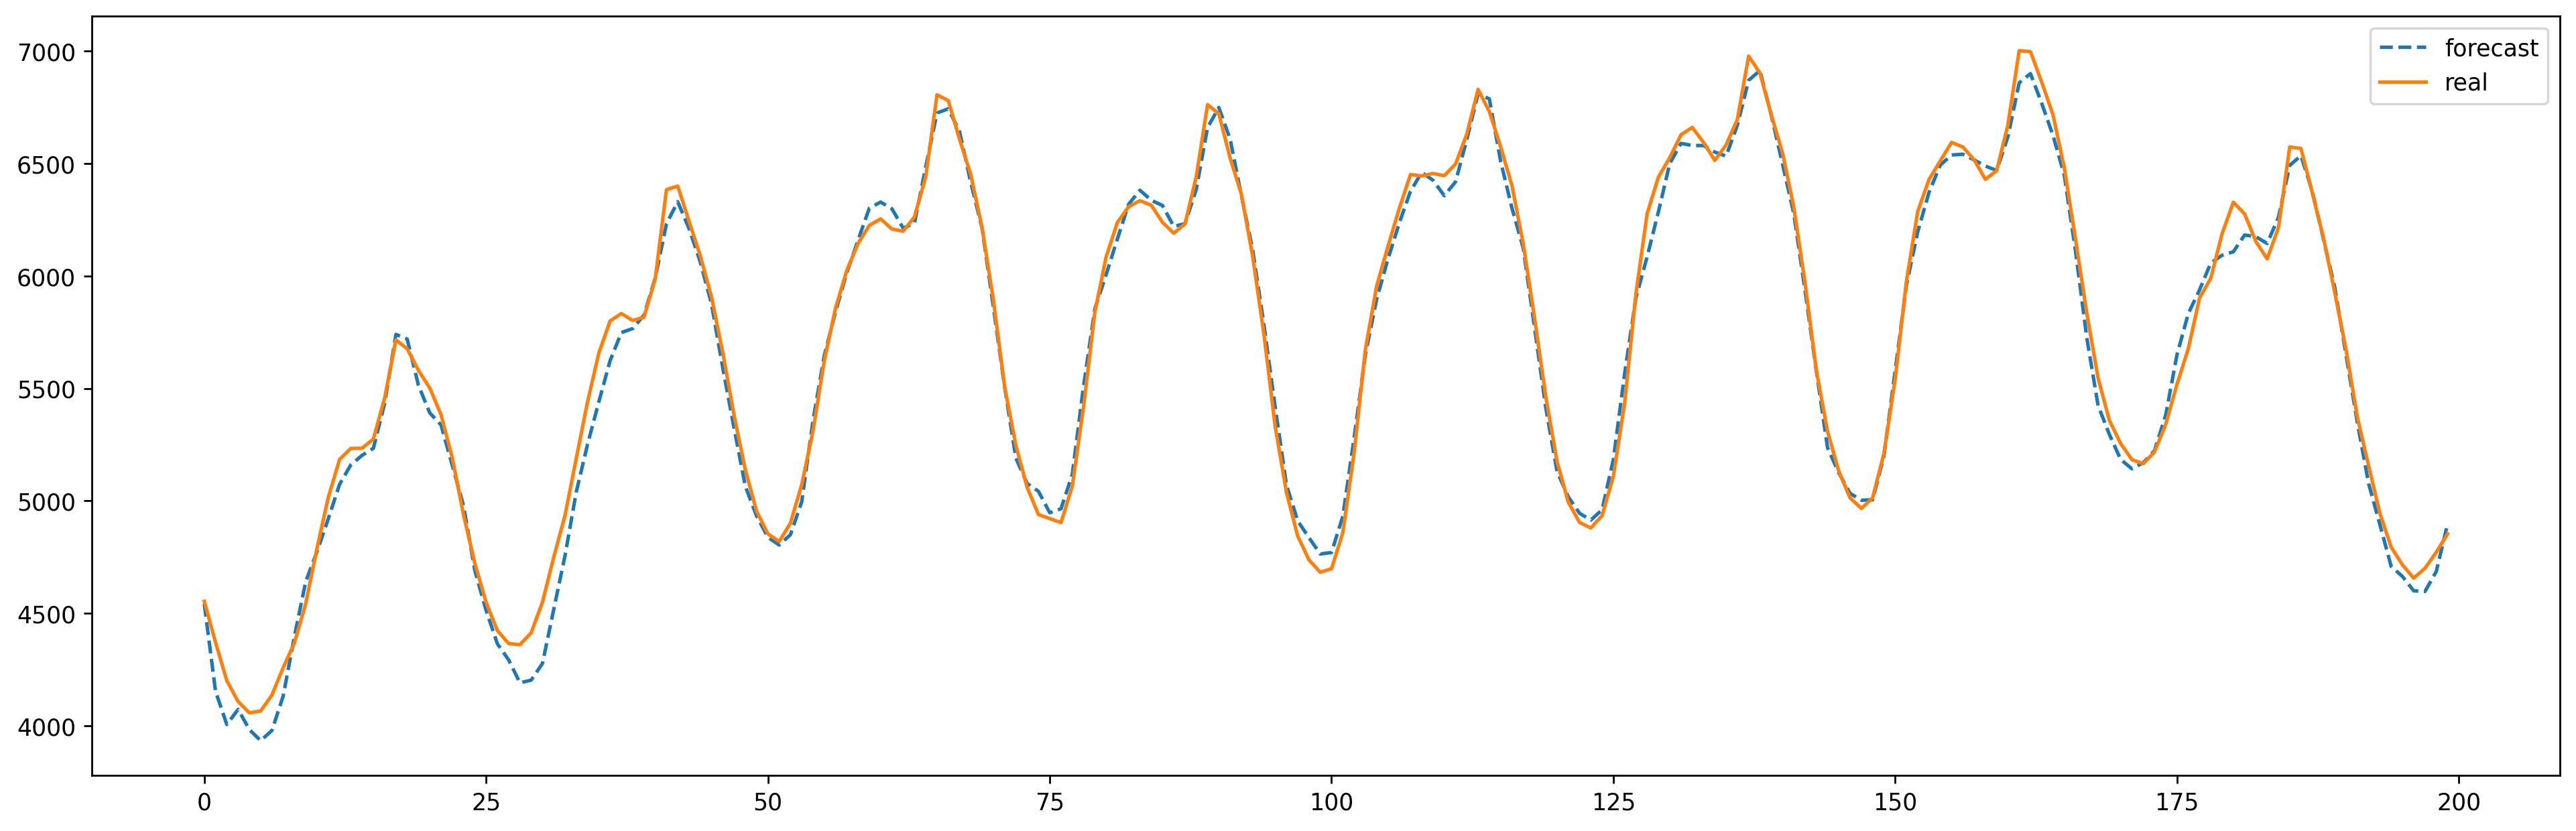

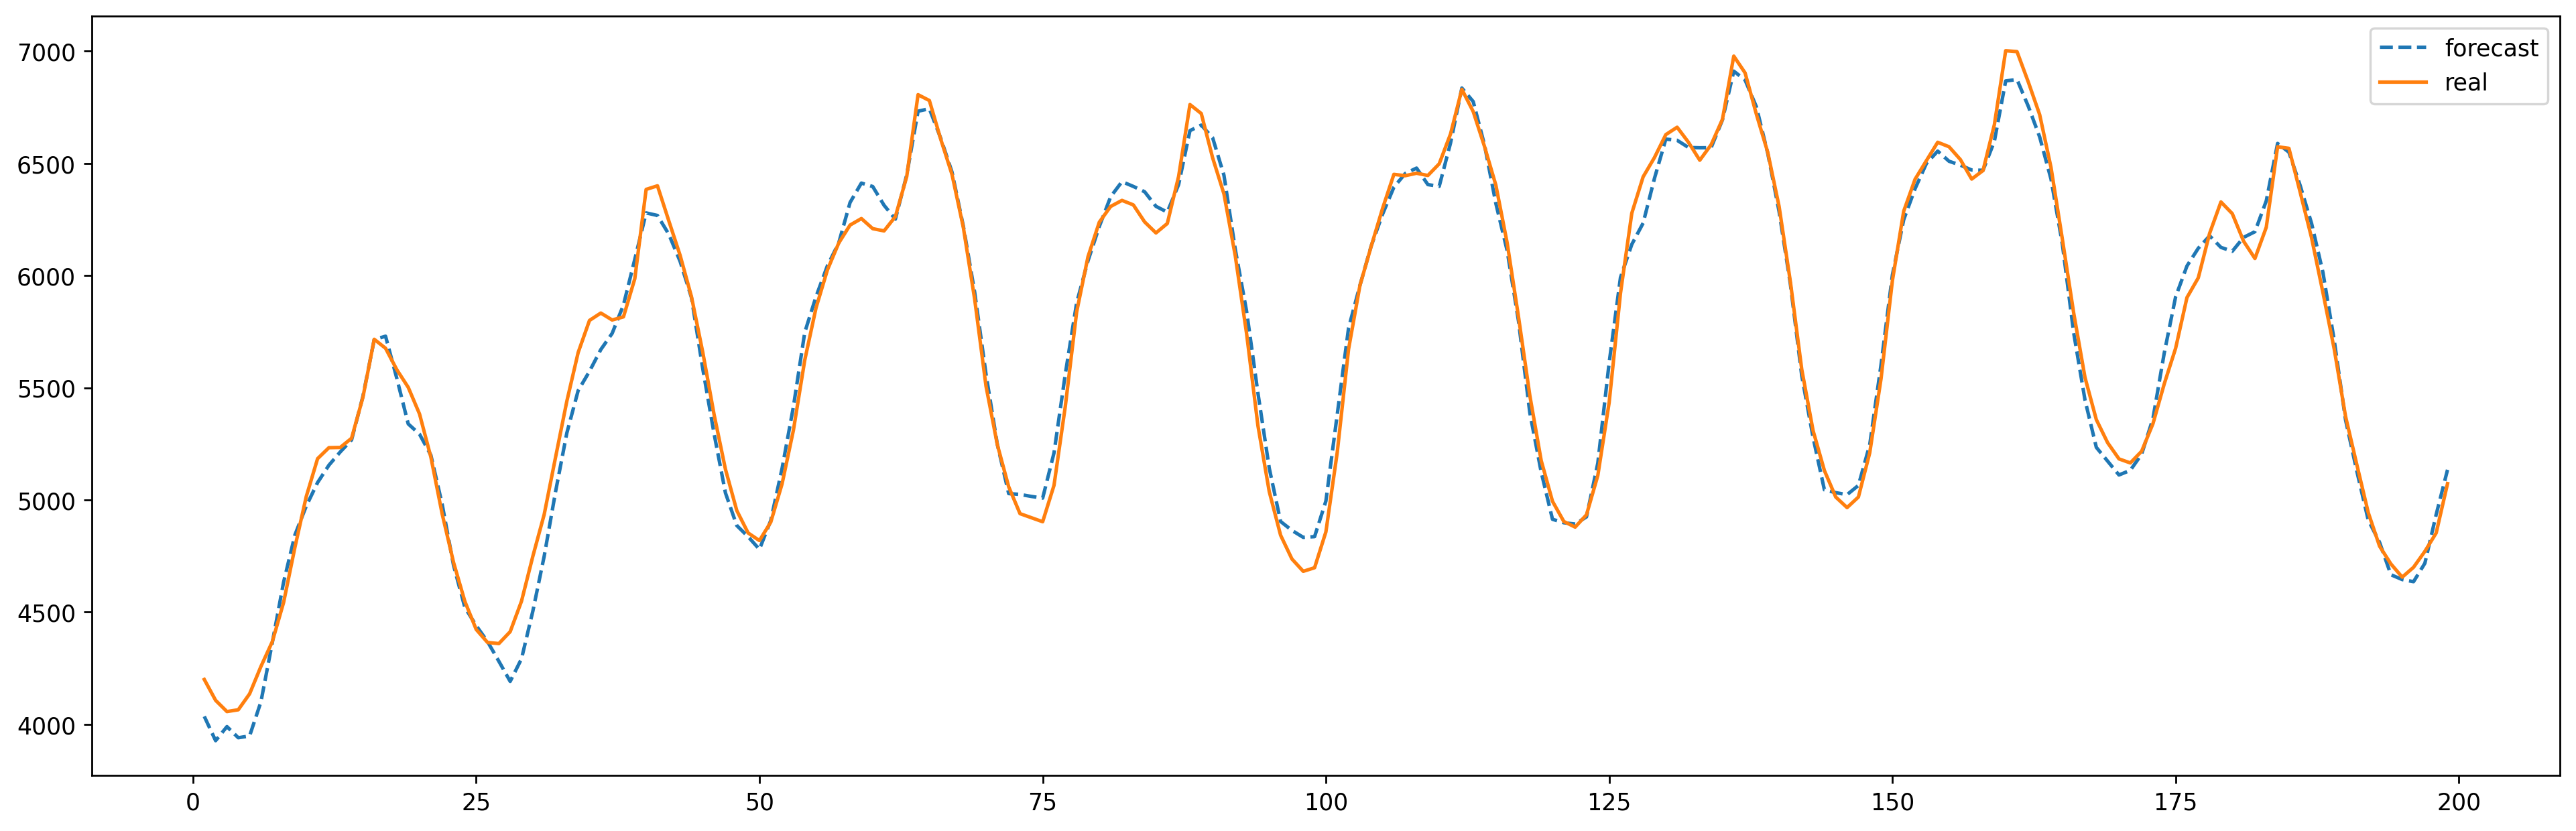

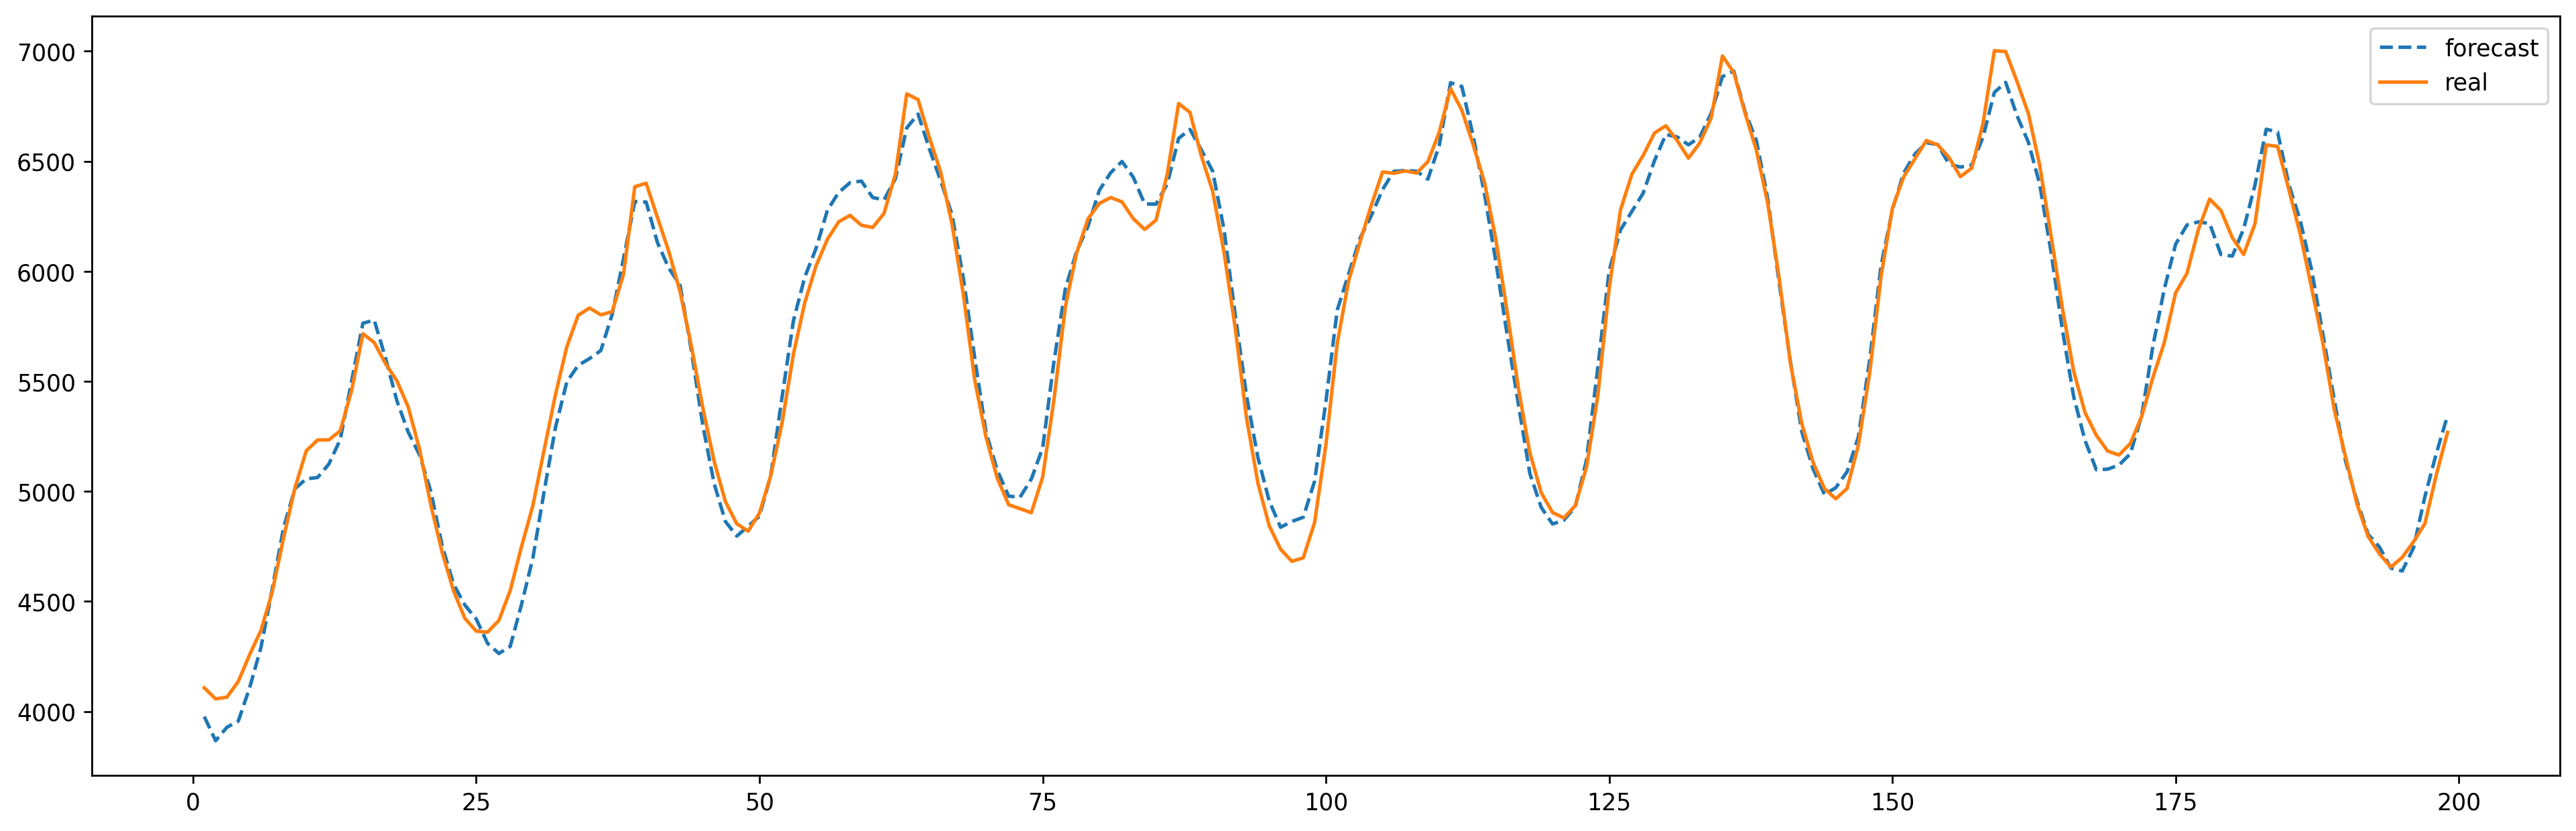

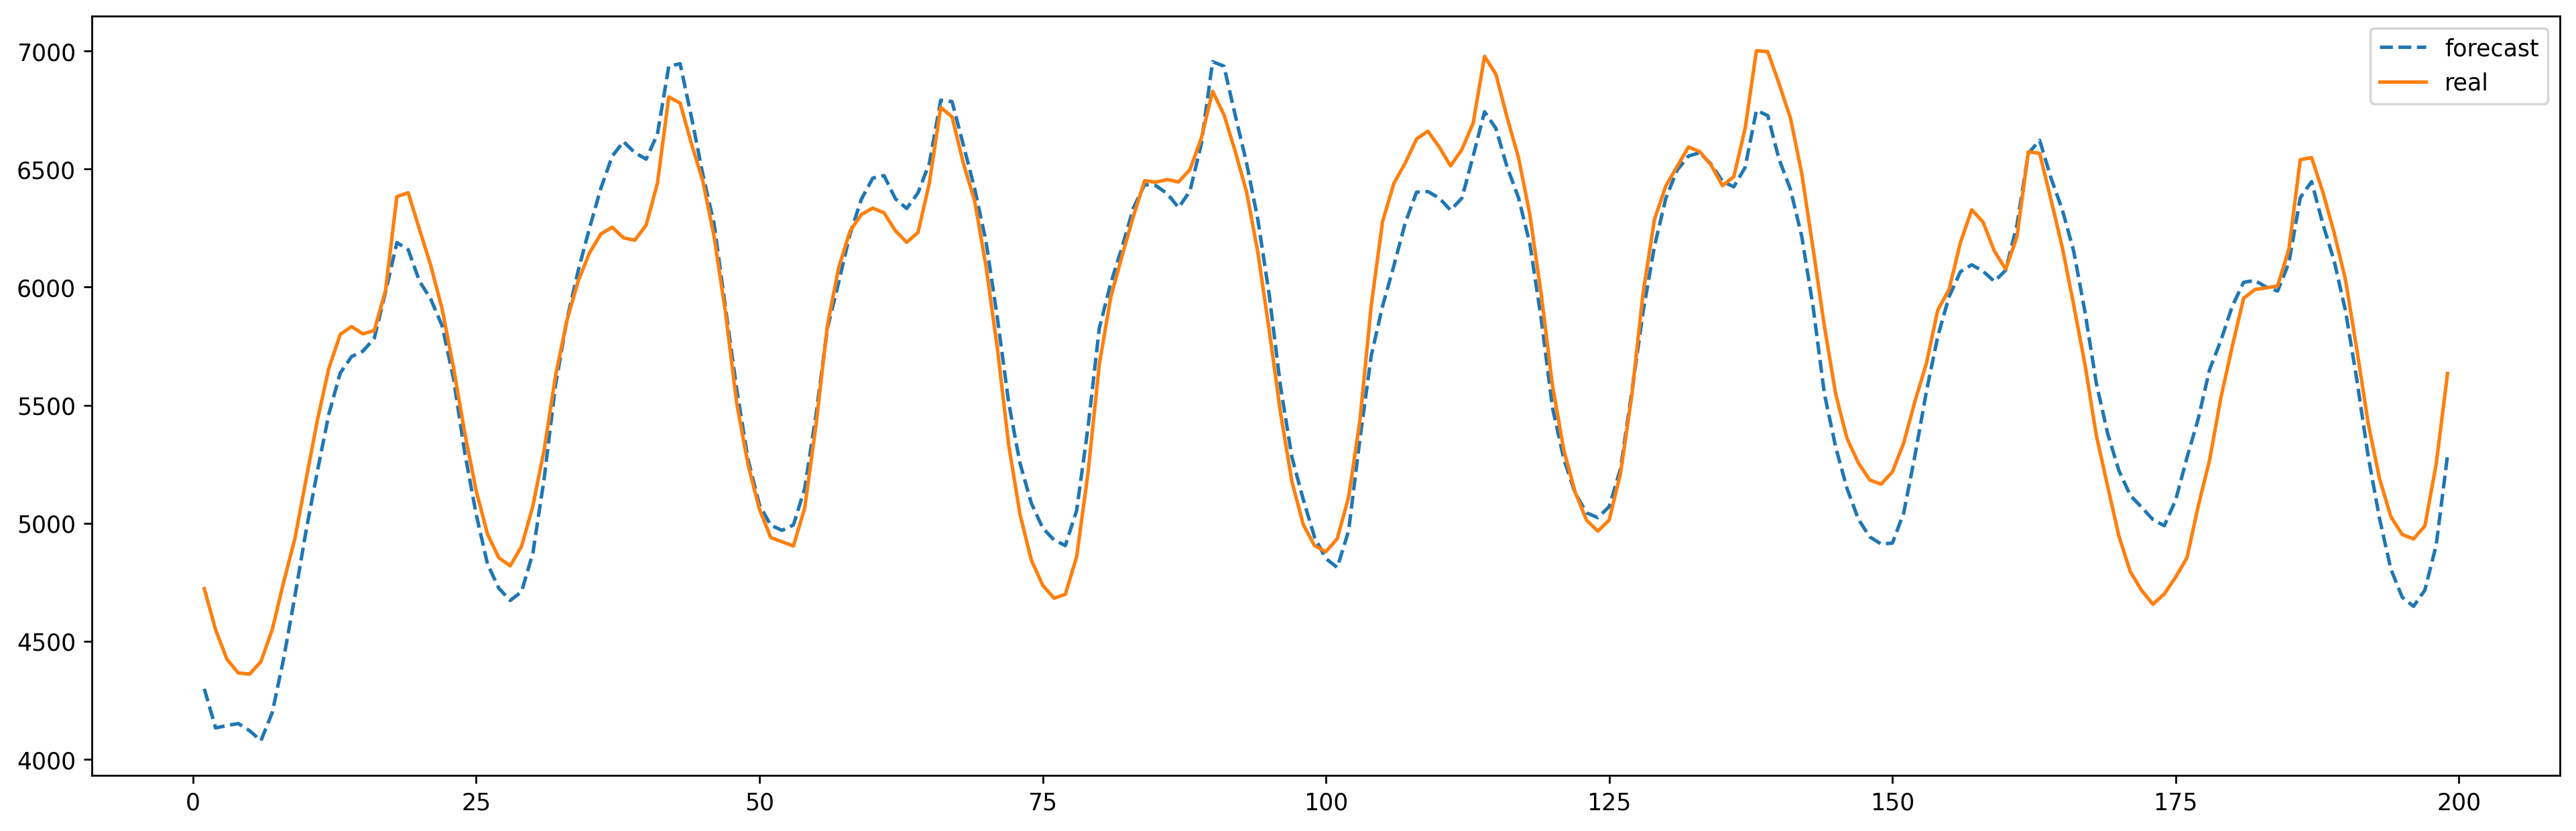

In [53]:
# create an empty dataframe  
df = pd.DataFrame()
df['forcasted_demand_1h'] = 0
df['forcasted_demand_2h'] = 0
df['forcasted_demand_3h'] = 0
df['forcasted_demand_24h'] = 0
df['real_demand_1h'] = 0
df['real_demand_2h'] = 0
df['real_demand_3h'] = 0
df['real_demand_24h'] = 0

for i in range(len(preds)):
    prediction_descaled=[]
    values_descaled=[]
    prediction_descaled = descale(descaler, preds[[i]].reshape(-1))
    values_descaled = descale(descaler, true[[i]].reshape(-1))
    new_row = {'forcasted_demand_1h':prediction_descaled[0], 
           'forcasted_demand_2h':prediction_descaled[1], 
           'forcasted_demand_3h':prediction_descaled[2],
           'forcasted_demand_24h':prediction_descaled[23],
           'real_demand_1h' : values_descaled[0],
           'real_demand_2h' : values_descaled[1],
           'real_demand_3h' : values_descaled[2],
           'real_demand_24h' : values_descaled[23]}
    
    df = df.append(new_row, ignore_index=True)

print('error for next 1 hour prediction')
error_1h = calculate_metrics(df.forcasted_demand_1h,df.real_demand_1h )
print("\n")
print('error for next 2 hour prediction')
error_2h = calculate_metrics(df.forcasted_demand_2h,df.real_demand_2h )
print("\n")
print('error for next 3 hour prediction')
error_3h = calculate_metrics(df.forcasted_demand_3h,df.real_demand_3h )
print("\n")
print('error for next 24 hour prediction')
error_24h = calculate_metrics(df.forcasted_demand_24h,df.real_demand_24h )
print("\n")



print('1-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[0:200], df.forcasted_demand_1h[0:200], "--", label="forecast")
plt.plot(dates[0:200], df.real_demand_1h[0:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('2-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[1:200], df.forcasted_demand_2h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_2h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('3-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_3h))
plt.plot(dates[1:200], df.forcasted_demand_3h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_3h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();


print('24-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_24h))
plt.plot(dates[1:200], df.forcasted_demand_24h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_24h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

Visualizing the seires (the next 24-hour forecast)

In [54]:
prediction_descaled=[]
values_descaled=[]
for i in range(len(preds)):
    prediction_descaled.append(descale(descaler, preds[[i]].reshape(-1)))
    values_descaled.append(descale(descaler, true[[i]].reshape(-1)))

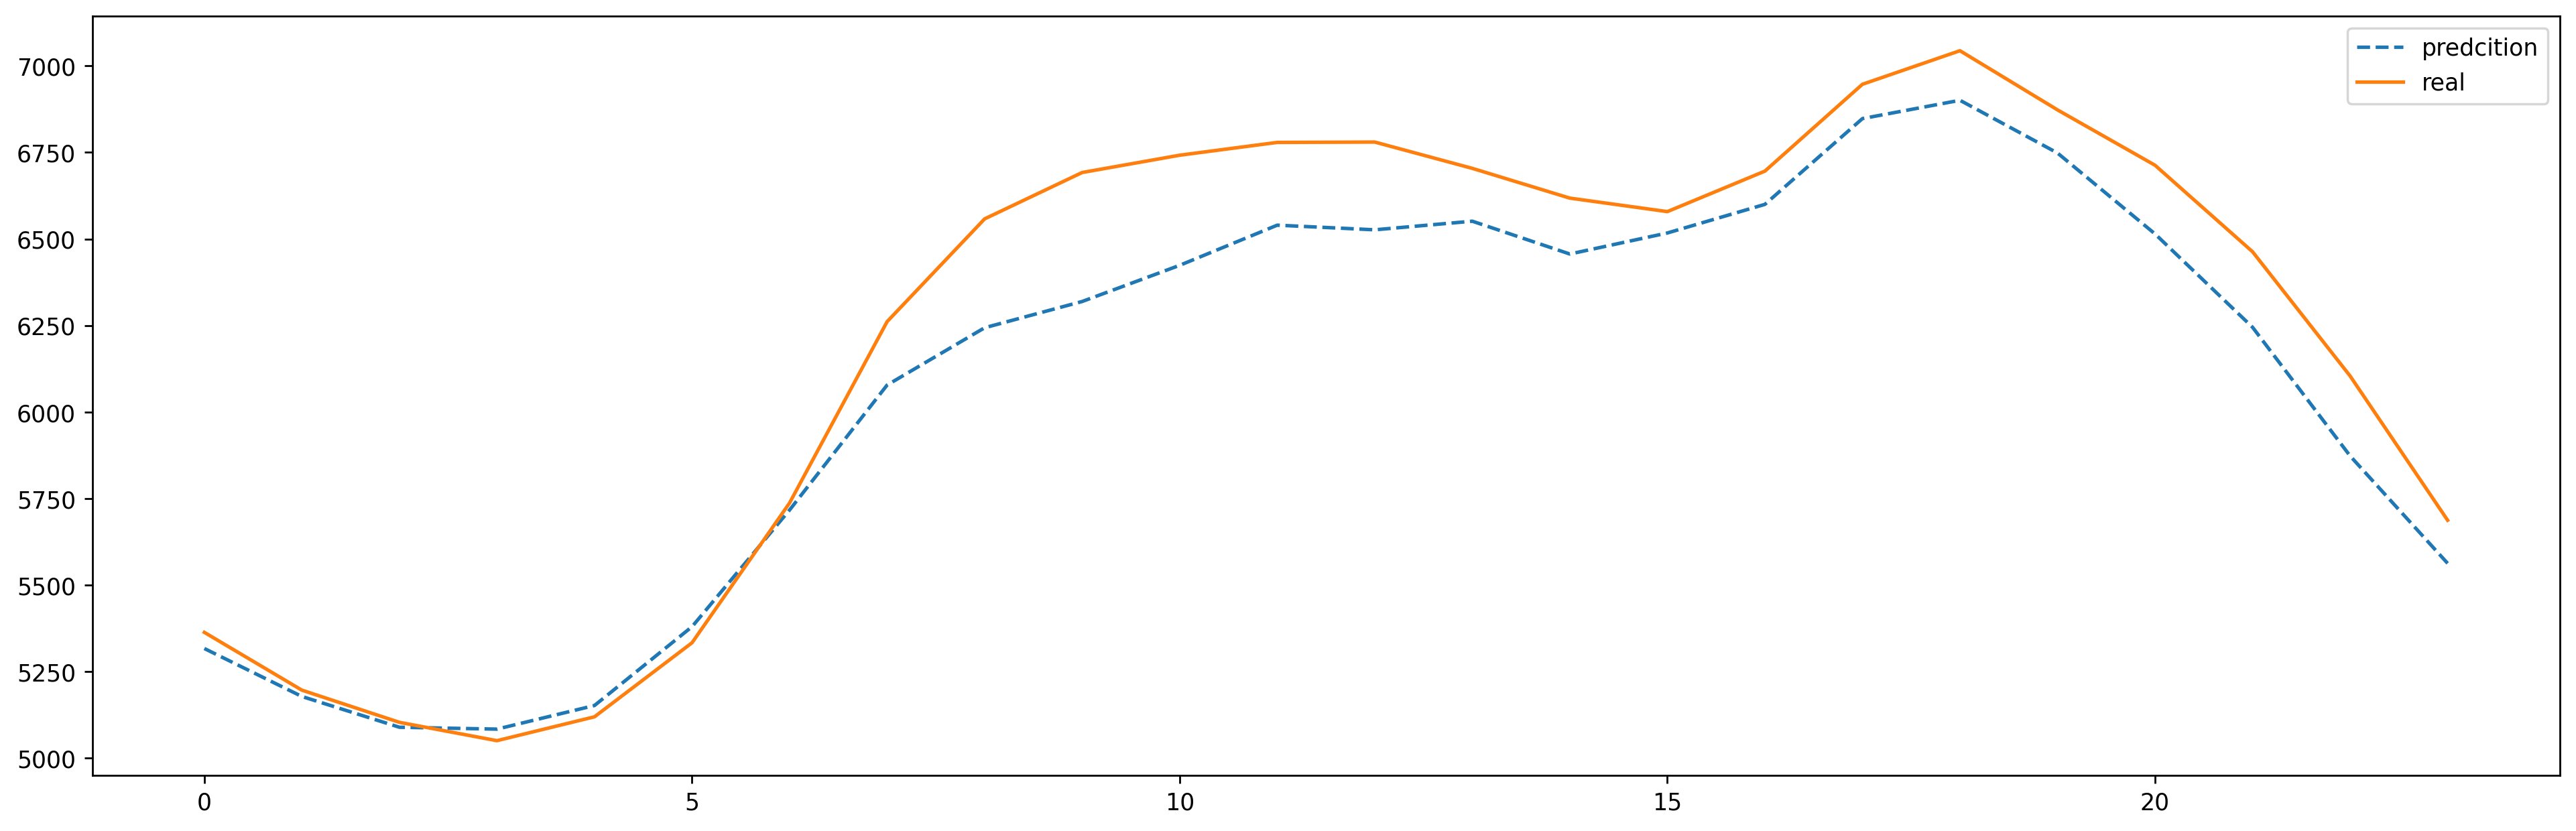

In [58]:
figure(figsize=(19, 6), dpi=250)

j=30*24
dates = range(len(prediction_descaled[j]))
plt.plot(dates[0:24], prediction_descaled[j] , "--", label="predcition")
plt.plot(dates[0:24], values_descaled[j], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();
